# Introduction
## Content:
- Aim: To show how to use BayesRTO.py
1. Apply BayesRTO on Benoit Problem

In [12]:
import jax
from jax import grad, value_and_grad, jit, vmap
import jax.numpy as jnp
from scipy.optimize import minimize, fsolve
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import pandas as pd
from IPython.display import Image

import BayesRTOjax
import Benoit_Problem

# 1. Benoit Problem
## A. Code for Drawings and GIFs

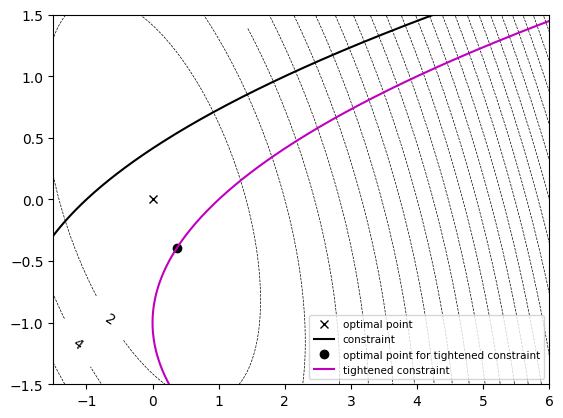

In [13]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = jnp.arange(-6.5, 6.5, delta)
        y = jnp.arange(-6.5, 6.5, delta)
        u = jnp.meshgrid(x, y)
        levels = jnp.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_Problem.Benoit_System_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                plt.plot(0,0,'kx')
                
                # Plot for constraint
                uc0 = 1. + x**2 + 2.*x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:
                # Plot for optimal value for optimization with tightened constraint
                plt.plot(0.36845785, -0.39299271,'ko')

                # Plot for tightened constraint
                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# Plot trust region circle
def trustregion_drawing(r,input_0,input_1):
       
        d_trial_x = jnp.linspace(-r, r, 50)
        d_trial_ypos= []
        d_trial_yneg = []
        equations = lambda d: [r - jnp.linalg.norm(d),d[0] - j]
        for j in d_trial_x: 
                initial_guess = [0,0]
                d = fsolve(equations,initial_guess)
                d_trial_ypos.append(d[1])
                d_trial_yneg.append(-d[1])

        d_trial_ypos = jnp.array(d_trial_ypos)
        d_trial_yneg = jnp.array(d_trial_yneg)

        plt.plot(d_trial_x+input_0,d_trial_ypos+input_1,'k-',linewidth=0.5)
        plt.plot(d_trial_x+input_0,d_trial_yneg+input_1,'k-',linewidth=0.5)

def BRTO_Benoit_drawing(data):
        plt.figure()
        # Drawing for Benoit's Problem
        plant_drawing(is_constraint = False,is_tight_constraint = True)

        # Plot points for input observed
        plt.plot(data['input_0'],data['input_1'], 'ro')
        plt.plot(data['input_0'],data['input_1'],'b-',linewidth=1,label='_nolegend_')

        n_iter = len(data['input_0'])
        for i in range(n_iter):
                trustregion_drawing(data['r'][i],data['input_0'][i],data['input_1'][i])

def create_frame(fun_drawing,t,filename):
        fun_drawing
        plt.savefig(filename)
        plt.close()

def create_GIF(frame_duration,filenames,GIFname,output_dir='output'):
        # create a GIF from saved frames
        frame_duration = 1000
        gif_path = os.path.join('..',output_dir, GIFname)
        with imageio.get_writer(gif_path, mode='I', duration=frame_duration) as writer:
                for filename in filenames:
                        image = imageio.imread(filename)
                        writer.append_data(image)
        # remove individual frame files
        for filename in filenames:
                os.remove(filename)

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()



## B. Without Uncertainty

iteration: 0
subkey: [3923418436 1366451097]
multi_start: 0
multi_start: 1
multi_start: 2
multi_start: 3
multi_start: 4
iteration: 1
subkey: [1371681402 3011037117]
multi_start: 0
multi_start: 1
multi_start: 2
multi_start: 3
multi_start: 4
iteration: 2
subkey: [1011144354 1829851133]
multi_start: 0
multi_start: 1
multi_start: 2
multi_start: 3
multi_start: 4
iteration: 3
subkey: [4049721409 3051634595]
multi_start: 0
multi_start: 1
multi_start: 2
multi_start: 3
multi_start: 4
iteration: 4


KeyboardInterrupt: 

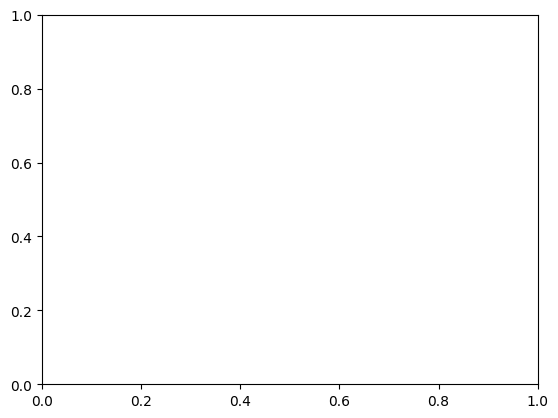

In [14]:
###################################################################################
###########################______GP Initialization______###########################
###################################################################################
'''
Description:
    It does as follows:
    1. Collects samples
    2. Find optimal parameters
    3. Initializes GP.
Arguments:
    n_sample        : number of samples to collect your input for GP initialization
    u_0             : initial input u (center point of area where you collect  of samples)
    theta_0         : initial parameter values for model [parameters for obj fun, parameters for constraint 1, parameters for constraint 2,...]
    r               : initial radius of trust region
    plant_system    : array with elements of plant objective function and constraints
    model           : array with elements of model objective function and constraints
Returns:
    GP_m            : a Gaussian Process Model
'''
n_sample            = 4
x_0                 = jnp.array([1.4,-0.8])
r                   = 0.5
plant_system        = [Benoit_Problem.Benoit_System_1,
                       Benoit_Problem.con1_system_tight]
GP_m = BayesRTOjax.BRTO(plant_system)
X,Y = GP_m.Data_sampling(n_sample,x_0,r)
GP_m.GP_initialization(X,Y,'RBF',multi_hyper=2)


#######################################################################################
###########################______Bayesian Optimization______###########################
#######################################################################################
n_iter = 10
b = 0.
# Dictionary for data collection
data = {}
data['input_0'] = [x_0[0]]
data['input_1'] = [x_0[1]]
data['GP model output'] = [GP_m.GP_inference_np(x_0)[0][0]]
data['GP model constraint'] = [GP_m.GP_inference_np(x_0)[0][1]]
data['plant output'] = [plant_system[0](x_0)]
data['plant constraint'] = [plant_system[1](x_0)]
data['r'] = [r]
# Parameters for GIF
filenames = []

for i in range(n_iter):
    print(f"iteration: {i}")
    # Create Frame
    t = i * 0.1
    filename = f'frame_{i:02d}.png'
    create_frame(BRTO_Benoit_drawing(data),t,filename)
    filenames.append(filename)

    # Bayesian Optimization
    # 1. New Observation
    d_new, obj= GP_m.optimize_acquisition(r,x_0,b=b,multi_start=5)    
    
    # 2. Collect data
    x_new = x_0 + d_new  
    output_new = []
    for plant in plant_system:
        output_new.append(plant(x_new))  
    output_new = jnp.array(output_new)
    # 3. Re-initialize Gaussian Process with new data                       
    GP_m.add_sample(x_new,output_new)                                                               

    # 4. Preparation for next iteration:
    x_0 = x_new

    # Data Collection
    GP_inference = GP_m.GP_inference_np(x_0)
    data['input_0'].append(x_0[0])
    data['input_1'].append(x_0[1])
    data['GP model output'].append(GP_inference[0][0])
    data['GP model constraint'].append(GP_inference[0][1])
    data['plant output'].append(plant_system[0](x_0))
    data['plant constraint'].append(plant_system[1](x_0))
    data['r'].append(r)

    if i == n_iter-1:
        # Create Last Frame
        t = n_iter * 0.1
        filename = f'frame_{n_iter:02d}.png'
        create_frame(BRTO_Benoit_drawing(data),t,filename)
        filenames.append(filename)

# Create GIF
frame_duration = 1000
GIFname = 'BRTO_Benoit.gif'
create_GIF(frame_duration,filenames,GIFname)

print(f"Final input: {data['input_0'][-1],data['input_1'][-1]}")

### Graphical Illustration

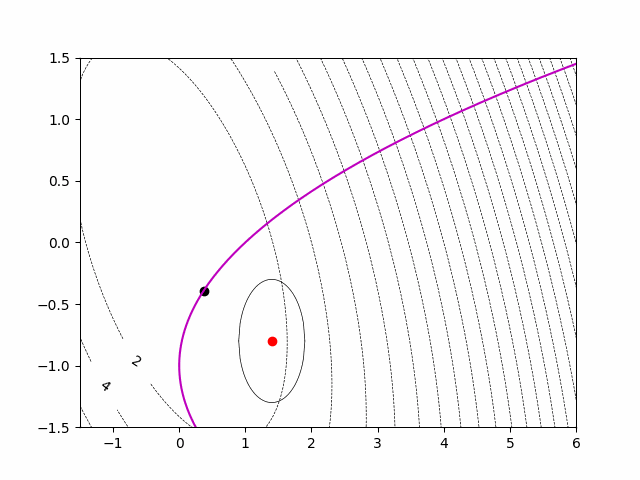

In [ ]:
Image(os.path.join('..','output', "BRTO_Benoit.gif"))

In [ ]:
pd.DataFrame(data)

,input_0,input_1,GP model output,GP model constraint,plant output,plant constraint,r
0,1.4,-0.8,1.5238929,1.3390558,1.4799999,1.3599999,0.5
1,0.94594604,-0.5906317,0.68495786,0.778396,0.684954,0.77836365,0.5
2,0.85202014,-0.33941454,0.5519216,0.41577965,0.55195254,0.415647,0.5
3,0.8520343,-0.33950853,0.55214685,0.4163177,0.5519555,0.41578528,0.5
4,0.8520247,-0.33939636,0.5525768,0.4153826,0.5519619,0.4156275,0.5
5,0.85202503,-0.33939457,0.55208874,0.41571105,0.5519626,0.4156255,0.5
6,0.8519871,-0.33954445,0.55273926,0.41784647,0.55188495,0.41578558,0.5
7,0.85202235,-0.3394049,0.5512738,0.4152271,0.5519572,0.41563648,0.5
8,0.8519997,-0.33945808,0.5519849,0.41606778,0.55191714,0.41568407,0.5
9,0.8520232,-0.3394048,0.55358005,0.41549534,0.5519584,0.41563717,0.5
